In [2]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn for preprocessing & modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# For evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, f1_score, roc_curve

# To handle class imbalance
from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_csv("creditcard.csv")

# Show the first 5 rows
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Basic info
print("Shape of dataset:", df.shape)
print("\nData types:")
print(df.dtypes)


Shape of dataset: (284807, 31)

Data types:
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object



Missing values:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Class distribution (0 = Non-Fraud, 1 = Fraud):
Class
0    284315
1       492
Name: count, dtype: int64


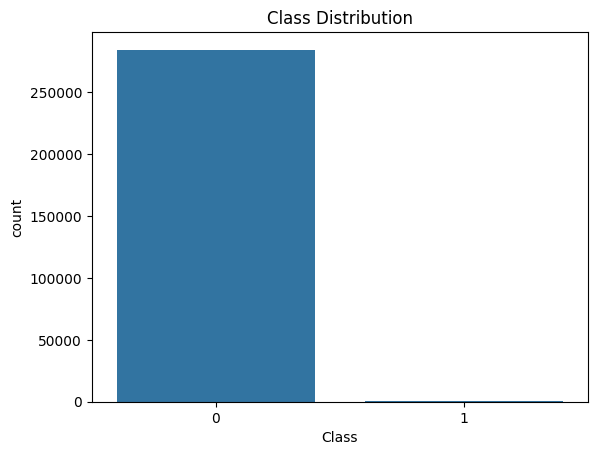

In [5]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check class distribution
print("\nClass distribution (0 = Non-Fraud, 1 = Fraud):")
print(df['Class'].value_counts())

# Plot class imbalance
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.show()

In [6]:
# Describe Time and Amount
df[['Time', 'Amount']].describe()


,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


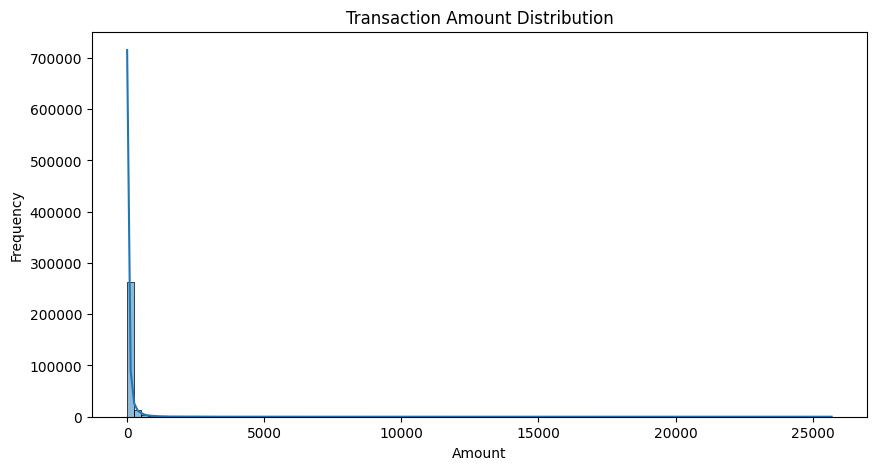

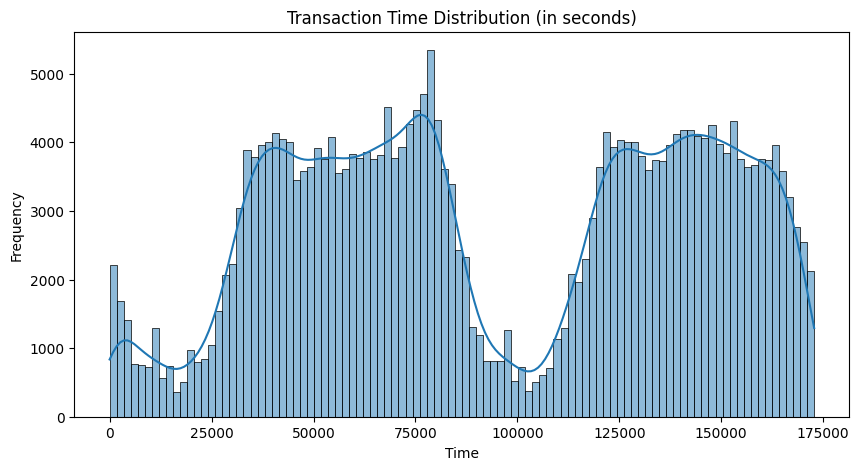

In [7]:
# Distribution of Transaction Amounts
plt.figure(figsize=(10,5))
sns.histplot(df['Amount'], bins=100, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

# Distribution of Transaction Time
plt.figure(figsize=(10,5))
sns.histplot(df['Time'], bins=100, kde=True)
plt.title('Transaction Time Distribution (in seconds)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()


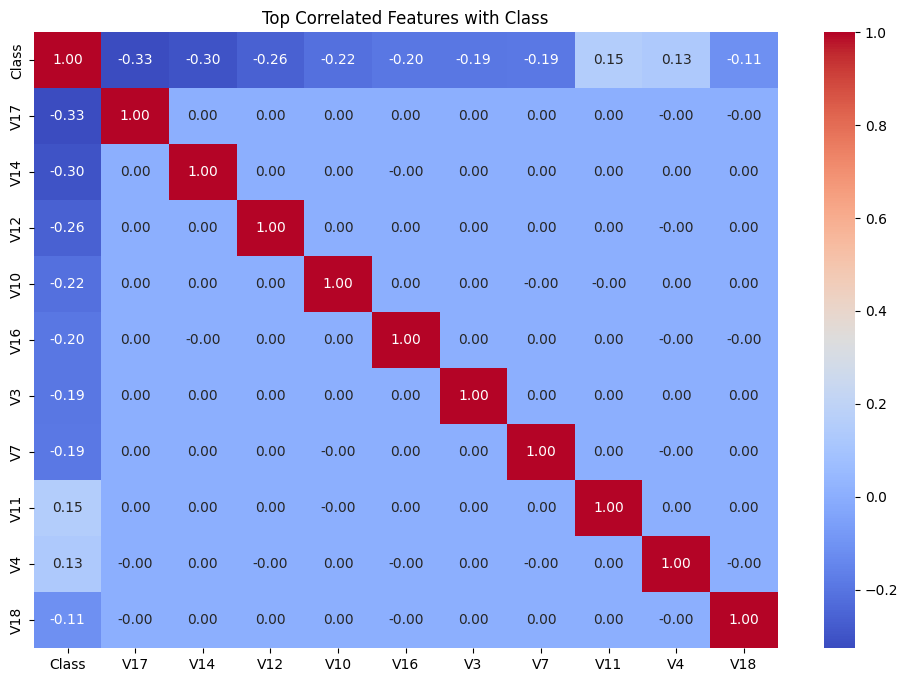

In [15]:
# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap (top 10 features most correlated with 'Class')
plt.figure(figsize=(12, 8))
top_corr_features = corr_matrix['Class'].abs().sort_values(ascending=False).head(11).index
sns.heatmap(df[top_corr_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Top Correlated Features with Class")
plt.show()



In [14]:
print(df.columns)

Index(['scaled_amount', 'scaled_time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6',
       'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16',
       'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26',
       'V27', 'V28', 'Class'],
      dtype='object')


In [16]:
# Step 1: Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Step 2: Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("\nTest class distribution:\n", y_test.value_counts(normalize=True))


Train class distribution:
 Class
0    0.998275
1    0.001725
Name: proportion, dtype: float64

Test class distribution:
 Class
0    0.998268
1    0.001732
Name: proportion, dtype: float64


In [17]:
# Step 3: Apply SMOTE
from imblearn.over_sampling import SMOTE

# Create SMOTE object
sm = SMOTE(random_state=42)

# Fit and resample only the training data
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Check the new class distribution
from collections import Counter
print("After SMOTE class distribution:")
print(Counter(y_train_res))


After SMOTE class distribution:
Counter({0: 199020, 1: 199020})


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Train the model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_res, y_train_res)

# Predict on test set
y_pred = lr_model.predict(X_test)
y_proba = lr_model.predict_proba(X_test)[:,1]

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix:
[[83376  1919]
 [   18   130]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9775    0.9885     85295
           1     0.0634    0.8784    0.1183       148

    accuracy                         0.9773     85443
   macro avg     0.5316    0.9279    0.5534     85443
weighted avg     0.9982    0.9773    0.9870     85443


ROC-AUC Score: 0.9659891030018235


In [20]:
# Check if rf_model exists in memory
'rf_model' in globals()


True

In [23]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("After SMOTE class distribution:\n", Counter(y_resampled))


After SMOTE class distribution:
 Counter({0: 199020, 1: 199020})


In [24]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_resampled, y_resampled)


RandomForestClassifier(random_state=42)

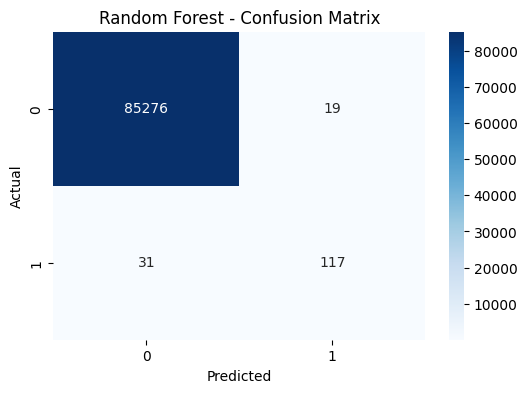

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.79      0.82       148

    accuracy                           1.00     85443
   macro avg       0.93      0.90      0.91     85443
weighted avg       1.00      1.00      1.00     85443

ROC AUC Score: 0.8952


In [25]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on original test set
rf_preds = rf_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, rf_preds))

# ROC AUC Score
rf_roc_auc = roc_auc_score(y_test, rf_preds)
print("ROC AUC Score:", round(rf_roc_auc, 4))


In [26]:
from xgboost import XGBClassifier

# Train XGBoost on SMOTE-balanced data
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_resampled, y_resampled)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:33:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [27]:
from sklearn.metrics import classification_report, roc_auc_score

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)
print("ROC AUC Score:", round(roc_auc_xgb, 4))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.76      0.80      0.78       148

    accuracy                           1.00     85443
   macro avg       0.88      0.90      0.89     85443
weighted avg       1.00      1.00      1.00     85443

ROC AUC Score: 0.9018


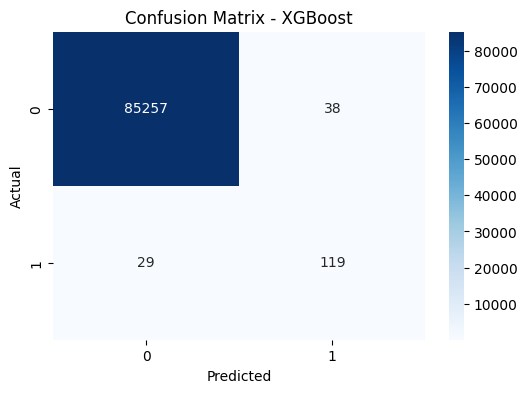

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


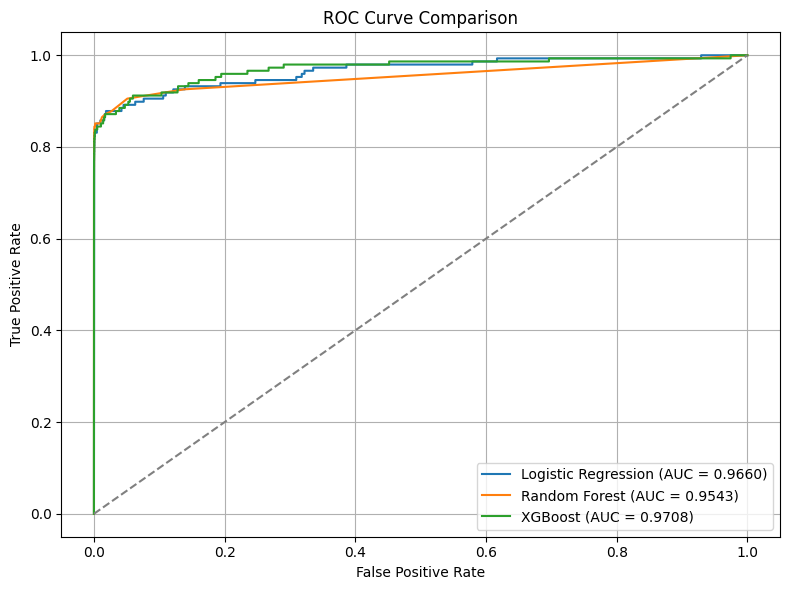

In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC Curve for Logistic Regression
lr_probs = lr_model.predict_proba(X_test)[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lr_auc = auc(lr_fpr, lr_tpr)

# ROC Curve for Random Forest
rf_probs = rf_model.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = auc(rf_fpr, rf_tpr)

# ROC Curve for XGBoost
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
xgb_auc = auc(xgb_fpr, xgb_tpr)

# Plotting all ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.4f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.4f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.4f})')

# Diagonal line (no skill)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
